In [11]:
from google.colab import files
files.upload()

{}

In [2]:
# Cria a pasta .kaggle e move o arquivo json para lá
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Define as permissões corretas para o arquivo
!chmod 600 ~/.kaggle/kaggle.json

# Baixa a base de dados "dogs-vs-cats" do Kaggle
# A flag -c indica o nome da competição
!kaggle competitions download -c dogs-vs-cats

# Descompacta o arquivo train.zip de forma silenciosa (-q)
# Isso criará uma pasta chamada 'train'
!unzip -q dogs-vs-cats.zip -d .

# Descompacta o arquivo train.zip de forma silenciosa (-q)
# Isso criará uma pasta chamada 'train'
!unzip -q train.zip -d .



100% 810M/812M [00:06<00:00, 233MB/s]
100% 812M/812M [00:06<00:00, 135MB/s]


In [3]:
import os
import shutil

# 1. Definir os caminhos no ambiente do Google Colab
# A pasta original com as imagens descompactadas
original_dir = '/content/train'

# A nova pasta onde vamos organizar os dados
base_dir = '/content/data_gatos_vs_caes'

# Não execute se a pasta base já existir (para evitar erros se rodar a célula de novo)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

    # 2. Criar os diretórios para gatos e cachorros dentro da pasta base
    cats_dir = os.path.join(base_dir, 'cats')
    os.mkdir(cats_dir)

    dogs_dir = os.path.join(base_dir, 'dogs')
    os.mkdir(dogs_dir)

    # 3. Pegar a lista de todos os nomes de arquivo da pasta original
    fnames = os.listdir(original_dir)

    print(f"Iniciando a movimentação de {len(fnames)} arquivos...")

    # 4. Mover os arquivos para as pastas corretas
    for fname in fnames:
        # Verifica se o nome do arquivo começa com 'cat'
        if fname.startswith('cat'):
            # Cria o caminho de origem e destino
            src = os.path.join(original_dir, fname)
            dst = os.path.join(cats_dir, fname)
            # Move o arquivo
            shutil.move(src, dst)

        # Verifica se o nome do arquivo começa com 'dog'
        elif fname.startswith('dog'):
            src = os.path.join(original_dir, fname)
            dst = os.path.join(dogs_dir, fname)
            shutil.move(src, dst)

    # 5. Imprimir um resumo
    print("\nOrganização dos arquivos concluída!")
    print(f"Total de imagens de gatos: {len(os.listdir(cats_dir))}")
    print(f"Total de imagens de cachorros: {len(os.listdir(dogs_dir))}")

else:
    print(f"A pasta '{base_dir}' já existe. Os arquivos provavelmente já foram organizados.")

Iniciando a movimentação de 25000 arquivos...

Organização dos arquivos concluída!
Total de imagens de gatos: 12500
Total de imagens de cachorros: 12500


In [4]:
# Célula 4: Carregar os dados e aplicar pré-processamento
import tensorflow as tf

# Agora você pode acessar o Keras com tf.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Parâmetros
img_height = 150
img_width = 150
batch_size = 32
data_dir = '/content/data_gatos_vs_caes' # Caminho da pasta organizada

# Carregar dados de treino (70%)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3, # Reservar 30% para validação e teste
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Carregar os 30% restantes
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Dividir os 30% em 15% para validação e 15% para teste
val_test_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take(val_test_batches // 2)
test_ds = val_test_ds.skip(val_test_batches // 2)

class_names = train_ds.class_names
print("Classes:", class_names)

# Otimizar performance do pipeline de dados
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Camada para aumento de dados
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

# Camada de normalização de pixels (0-255 para 0-1)
normalization_layer = layers.Rescaling(1./255)

Found 25000 files belonging to 2 classes.
Using 17500 files for training.
Found 25000 files belonging to 2 classes.
Using 7500 files for validation.
Classes: ['cats', 'dogs']


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Célula para construir o modelo com Dropout
model = Sequential([
    # A entrada do modelo com as dimensões da imagem
    layers.Input(shape=(img_height, img_width, 3)),

    # Camadas de pré-processamento que você já definiu
    normalization_layer,
    data_augmentation,

    # Bloco 1 de Convolução e Pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloco 2 de Convolução e Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Transforma os mapas de características 2D em um vetor 1D
    layers.Flatten(),

    # Camada Densa grande, seguida pelo Dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Camada final de saída para classificação binária
    layers.Dense(1, activation='sigmoid')
])

# Compila o novo modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Mostra o resumo da nova arquitetura

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,487,745 (162.08 MB)

 Trainable params: 42,487,745 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.5836 - loss: 0.7546 - val_accuracy: 0.6723 - val_loss: 0.6173
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.6807 - loss: 0.6040 - val_accuracy: 0.6958 - val_loss: 0.5821
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.7123 - loss: 0.5633 - val_accuracy: 0.7404 - val_loss: 0.5303
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.7329 - loss: 0.5327 - val_accuracy: 0.7553 - val_loss: 0.5066
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.7503 - loss: 0.5107 - val_accuracy: 0.7740 - val_loss: 0.4868
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.7588 - loss: 0.4947 - val_accuracy: 0.7756 - val_loss: 0.4904
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.7694 - loss: 0.4776 - val_accuracy: 0.7927 - val_loss: 0.4602
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.7775 - loss: 0.4653 - 

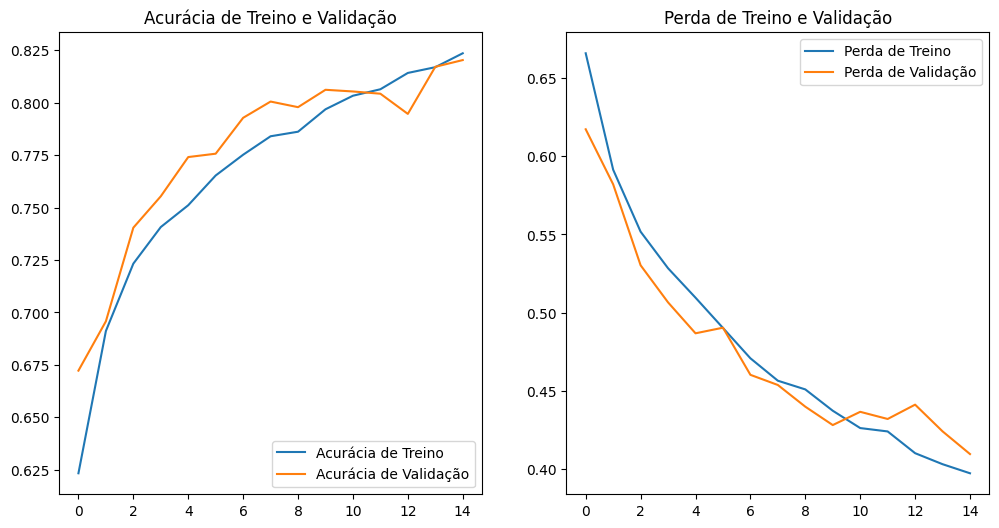

In [6]:
# Célula para treinar o modelo
epochs = 15 # O exercício pede pelo menos 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Célula para plotar os gráficos
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()

In [7]:
# Célula para avaliação com métricas
import numpy as np
from sklearn.metrics import classification_report

# Avalia a acurácia no conjunto de teste
print("Avaliando o modelo no conjunto de teste...")
loss, accuracy = model.evaluate(test_ds)
print(f"\nAcurácia no conjunto de teste: {accuracy:.2f}")

# Gera o relatório de classificação com precisão, recall e F1-Score
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Célula para testar com uma imagem nova
# ... (use o código do guia anterior para baixar uma imagem da web e testar) ...

Avaliando o modelo no conjunto de teste...
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8337 - loss: 0.3786

Acurácia no conjunto de teste: 0.82
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

        cats       0.84      0.79      0.81      1858
        dogs       0.81      0.86      0.83      1898

    accuracy                           0.82      3756
   macro avg       0.82      0.82      0.82      3756
weighted avg       0.82      0.82      0.82      3756



Saving gato.jpg to gato.jpg

Processando a imagem: gato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


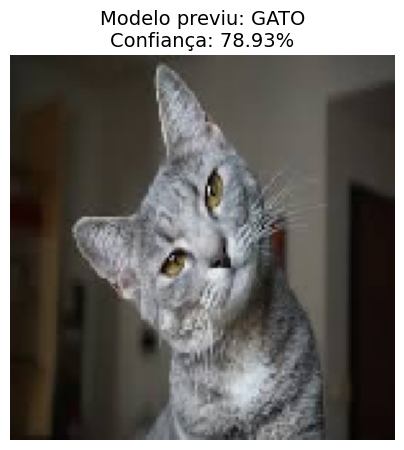

In [10]:
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Inicia o processo de upload de arquivos
uploaded = files.upload()

# Verifica se algum arquivo foi enviado
if not uploaded:
  print("\nNenhum arquivo foi selecionado. Execute a célula novamente para tentar de novo.")
else:
  # Loop para processar cada arquivo que foi enviado
  for filename, content in uploaded.items():
    print(f'\nProcessando a imagem: {filename}')

    # Salva o arquivo temporariamente no ambiente do Colab
    with open(filename, 'wb') as f:
      f.write(content)

    # Carrega e prepara a imagem para o modelo
    # (Usando as mesmas dimensões que o modelo foi treinado)
    img = tf.keras.utils.load_img(filename, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = tf.expand_dims(img_array, 0) # Cria um batch de 1 imagem

    # Faz a predição com o modelo já treinado
    prediction = model.predict(img_batch)
    score = prediction[0][0]

    # Define o resultado da classificação e a confiança
    if score < 0.5:
        predicted_class = "GATO"
        confidence = 100 * (1 - score)
    else:
        predicted_class = "CACHORRO"
        confidence = 100 * score

    # Mostra a imagem e o resultado da classificação
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Modelo previu: {predicted_class}\nConfiança: {confidence:.2f}%", fontsize=14)
    plt.axis('off')
    plt.show()

    # Apaga o arquivo temporário para limpar o ambiente
    os.remove(filename)